# Selecting the features for the model
This part of the project is focused on the selection of the features that has an impact on the target feature `churn`.
To do so we used the sklearn library to standadize the dataframe, and `f_classif` and `RandomForestClassifier` to determine
which feature is important, after which we created a function to finetune the selection based on a threshold.

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', None)
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import sklearn
import os
warnings.filterwarnings('ignore')

In [2]:
# Loading the clean_data
file = open(r'./data_files/cleaned_data.pk', 'rb')
clean_data = pickle.load(file)
file.close()

<b>In the cell below we created `feature_engineering` function to visually represent the most important feature using `f_classif` and `RandomForestClassifier` to see at a glance which of the features stands out.<b>

In [3]:
def feature_engineering():
    
    
    #The first five lines generate more features that can increase the relationship of the new columns with churns
    clean_data['total_cons'] = clean_data['cons_12m'] + clean_data['cons_gas_12m']
    clean_data['price'] = ((clean_data['price_p1_var'] + clean_data['price_p1_fix']) + (clean_data['price_p2_var'] + clean_data['price_p2_fix']) + (clean_data['price_p3_var'] + clean_data['price_p3_fix']))/3
    clean_data['aver_forcast_ene'] = (clean_data['forecast_price_energy_p1'] + clean_data['forecast_price_energy_p2'])/2
    clean_data['cons/price1'] = clean_data['total_cons']/clean_data['price']
    clean_data['forcast_price'] = (clean_data['forecast_price_energy_p1'] + clean_data['forecast_price_pow_p1'] + clean_data['forecast_price_pow_p1'])/2
    
    # The X variable is a list of columns except churn and the date columns with can render the model useless
    X = clean_data.drop(['churn', 'date_activ', 'date_end', 'date_renewal'], 1)
    y = clean_data.churn #The y variable just contain only the churn column
    X.replace(np.inf, 0, inplace=True) #Due to the new created columns some data point as a value of 1/0 which will arise into an error if being feed into the model so to aviod such error I replace all 1/0 or equivalent with 0
    
    
    # I standardize the X value using the sklearn package
    scaler = StandardScaler()  
    X_ = scaler.fit_transform(X)
    
    
    # I created a model, randomforestclassifier, to determine how my model is performing has as new column/feature are being added to my dataset
    model = RandomForestClassifier()
    score = cross_val_score(model, X_, y.values, scoring = 'roc_auc', n_jobs=-1)
    score = score.mean()
    #print('mean score using roc_auc {0:.2f}'.format(score))
    
    
    # randomforestclassifier has a parameter that can show the feature importances base on the model
    model.fit(X_, y.values)
    feature_importance = model.feature_importances_
    df_fea_imp = pd.Series(feature_importance, index = X.columns, name = 'feature_import')
    #print('\nfeature importance using random forest classifier\n', df_fea_imp.sort_values(ascending = False))
    
    
    # This another of way to check the feature importance of dataset for ordinal, categorical prediction
    k_best = SelectKBest(f_classif, k = 17)
    X_new = k_best.fit_transform(X_, y)
    impt = pd.Series(k_best.scores_, index = X.columns)
    #print('\nfeature importance using f_classifier\n', impt.sort_values(ascending = False))
    
    # Both of the method used in selecting the feature importance are put into graphical view
    fig = plt.figure(figsize = (25.0, 10.0))
    plt.subplot(1,2,1)
    df_fea_imp.sort_values(ascending = False).plot(kind = 'barh', title = 'feature importance using random forest classifier')
    plt.subplot(1,2,2)
    impt.sort_values(ascending = False).plot(kind = 'barh', title = 'Feature importance using f_classifier')
    fig.savefig(r'.\images\feature_importances.png')
    return df_fea_imp, impt

<b> The `feature_engineering` function returns the scores of both the `f_classif` and `RandomForestClassifier` which is needed for removing the least important features from the dataframe.</b>

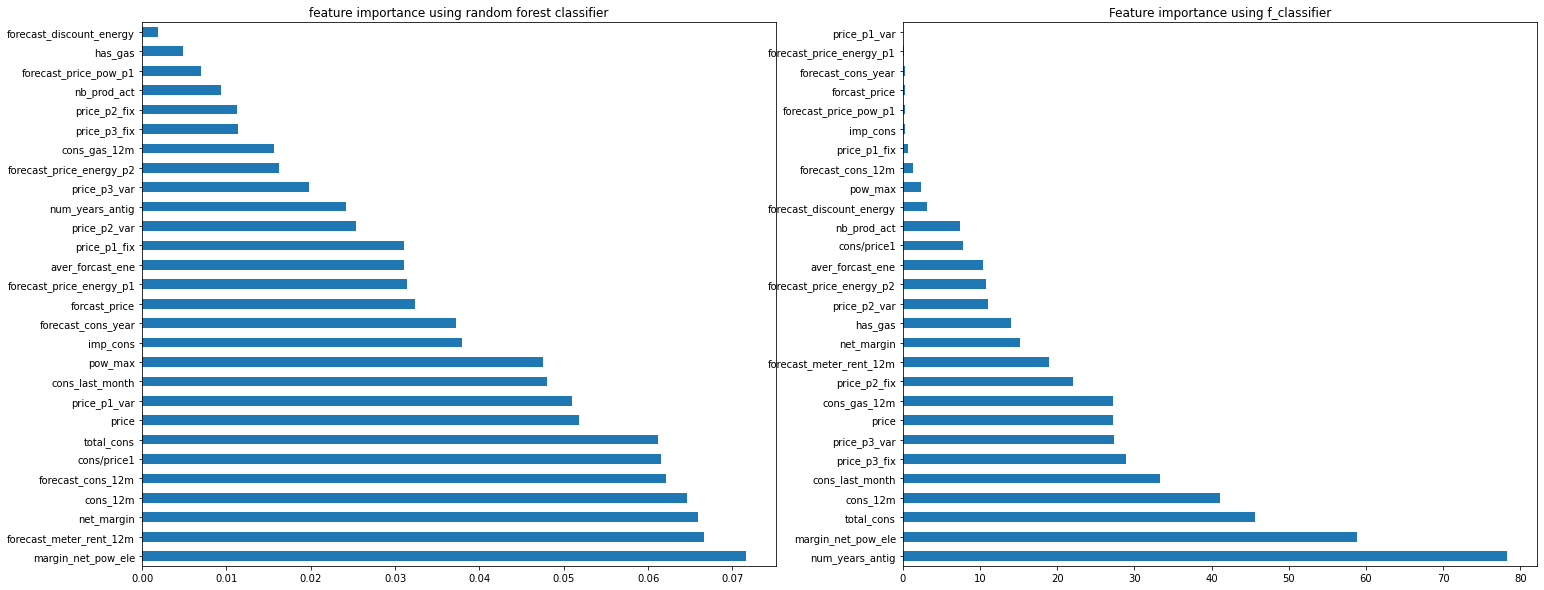

In [4]:
random_features_imp, f_classifier_imp = feature_engineering()

In [5]:
# A funtion that returns a series of important features based on a threshold
# The function accepts three parameters:
# data-the series of scores
# thresh - the threshold to select important features
# name - name of the method used in the scoring (f_classif, RandomForestClassifier)
def important_feature(data, thresh, model_used):
    dictionary = {}
    for feature in list(data.index):
        if data[feature] > thresh:
            dictionary[feature] = data[feature]

     # pd.DataFrame.from_dict(rf_imp_feat)
    return pd.Series(dictionary, name = model_used)

In [6]:
# features1 and features2 after removing the less important features
features1 = important_feature(random_features_imp, 0.037, 'random_forest').sort_values(ascending=False)
features2 = important_feature(f_classifier_imp, 20, 'f_classifier').sort_values(ascending=False)

### The dataframe of important features
As we can see the dataframe now has 18 columns out of the original 32 columns

In [7]:
features = pd.concat([features1, features2], axis=1).index.tolist()
features_df = clean_data[features].reset_index(drop=True)
print('Number of columns before feature selecton: %d\n' % clean_data.shape[1],
      'Number of columns after feature selection %d' % features_df.shape[1])

Number of columns before feature selecton: 32
 Number of columns after feature selection 18


## The dataframe we are going to work with

In [8]:
features_df

,margin_net_pow_ele,forecast_meter_rent_12m,net_margin,cons_12m,forecast_cons_12m,cons/price1,total_cons,price,price_p1_var,cons_last_month,pow_max,imp_cons,forecast_cons_year,num_years_antig,price_p3_fix,price_p3_var,cons_gas_12m,price_p2_fix
0,-41.76,359.29,1732.36,309275,26520.30,8928.842577,309275,34.637748,0.103449,10025,180.000,831.80,10025,3,8.337051,0.067241,0,36.356887
1,25.44,1.78,678.99,0,0.00,2020.627875,54946,27.192538,0.122856,0,43.648,0.00,0,3,16.256008,0.072579,54946,24.384011
2,16.38,16.27,18.89,4660,189.95,314.402115,4660,14.821783,0.149934,0,13.800,0.00,0,6,0.000000,0.000000,0,0.000000
3,28.60,38.72,6.60,544,47.96,36.555550,544,14.881461,0.170512,0,13.856,0.00,0,6,0.000000,0.000000,0,0.000000
4,30.22,19.83,25.46,1584,240.04,106.663134,1584,14.850492,0.151210,0,13.200,0.00,0,6,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15911,27.88,18.57,381.77,32270,4648.01,5405.622791,80210,14.838253,0.144124,0,15.000,0.00,0,4,0.000000,0.000000,47940,0.000000
15912,0.00,144.03,90.34,7223,631.69,208.300705,7223,34.675831,0.106799,181,6.000,15.94,181,3,8.345418,0.070817,0,36.393379
15913,39.84,129.60,20.38,1844,190.39,67.707196,1844,27.234919,0.124338,179,15.935,18.05,179,4,16.280694,0.073160,0,24.421038
15914,13.08,7.18,0.96,131,19.34,8.838343,131,14.821783,0.149934,0,11.000,0.00,0,3,0.000000,0.000000,0,0.000000
